# DASHBOARD

This notebook serves as a dashboard to reproduce what I had on Gravitus.

Date : 29 May 2022

@author: jeremylhour

# 1. Import packages and load the data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import json
import yaml
from datetime import datetime
from dateutil.relativedelta import relativedelta

from src.workout_tools import get_historical_performance, lbs_to_kg

plt.rcParams['figure.figsize'] = [14, 10]

# Dates des confinements en France
CONFINEMENTS = [
    ("2020-03-17", "2020-05-11"),
    ("2020-10-30", "2020-12-15"),
    ("2021-04-03", "2021-05-03")
]

In [18]:
def plot_historical_e1RM(e1RM, exercise, tonnage=None, ax=None, rolling_window=10):
    """
    plot_historical_e1RM:
        plot estimated 1-rep max for a given exercise
    
    @param e1RM (pd.DataFrame):
    @param exercise (str): name of the exercise
    @param tonnage (pd.DataFrame):
    @param ax ():
    @param rolling_window (int):
    """
    # e1RM
    e1RM_for_plot = e1RM.dropna().sort_index().resample("W", label='left').max().rolling(f"{rolling_window}D").mean()
    
    if ax is None:
        fig, ax = plt.subplots()
    ax.set_title(label=f'{exercise}, estimated 1-rep max (kg), {rolling_window} day-average, best e1RM: {round(e1RM.max(), 1)} kg')

    ax.plot(e1RM_for_plot.index, e1RM_for_plot, color="red")
    ax.plot(e1RM_for_plot.index, e1RM_for_plot.ffill(), color="red", linestyle=":")
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.xaxis.set_minor_locator(mdates.MonthLocator((1,4,7,10)))
    ax.xaxis.set_minor_formatter(mdates.DateFormatter('%b'))
    ax.set_xlabel("Date", fontsize=14)
    ax.set_ylabel("e1RM (kg)", color="red", fontsize=14)
    plt.sca(ax)
    _=plt.xticks(rotation=30)
    
    if tonnage is not None:
        tonnage = tonnage.dropna().sort_index().resample("W", label='left').sum().rolling(f"{rolling_window}D").mean()
        ax2 = ax.twinx()
        ax2.plot(tonnage.index, tonnage, color="blue", linestyle="dashed")
        ax2.set_ylabel("Tonnage (kg)", color="blue", fontsize=14)
        ax2.xaxis.set_major_locator(mdates.YearLocator())
        ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
        ax2.xaxis.set_minor_locator(mdates.MonthLocator((1,4,7,10)))
        ax2.xaxis.set_minor_formatter(mdates.DateFormatter('%b'))
        plt.sca(ax2)
        _=plt.xticks(rotation=30)

    
    for period in CONFINEMENTS:
        if e1RM_for_plot.index.min() < pd.to_datetime(period[1]):
            ax.fill_between(period, e1RM_for_plot.max()*1.1, color='grey', alpha=.5)

In [3]:
CONFIG_FILE = 'config/gravitus.yaml'

with open(CONFIG_FILE, 'r') as stream:
    config = yaml.safe_load(stream)

DATA_PATH = config.get('OUT_FOLDER')+"/"+str(config.get('USER_ID'))+"/parsed_data.json"

with open(DATA_PATH, 'rb') as f:
    workoutInfos = json.load(f)

In [4]:
TRACKER_FILE = 'config/tracker.yaml'

with open(TRACKER_FILE, 'r') as stream:
    tracker = yaml.safe_load(stream)

In [5]:
# Get own training logs
with open("data/manual_data/parsed_training_log.json", 'rb') as f:
    trainingLog = json.load(f)

# 2. Process data

## A. Processing Gravitus data

In [6]:
EXERCISES = tracker.get("SBD") + tracker.get("EXTRA")
e1RM = {}
tonnage = {}
for exercise in EXERCISES:
    print(f"Processing Gravitus data for {exercise}...")
    e1RM[exercise] = get_historical_performance(exercise, workoutInfos)
    tonnage[exercise] = get_historical_performance(exercise, workoutInfos, mode="tonnage")

Processing Gravitus data for Squat...
Processing Gravitus data for Paused Bench Press...
Processing Gravitus data for Deadlift...
Processing Gravitus data for Overhead Press...


## B. Processing training log data

In [7]:
for exercise in EXERCISES:
    print(f"Processing log data for {exercise}...")
    from_training_log = get_historical_performance(exercise, trainingLog, convert_to_kg = False)
    e1RM[exercise] = pd.concat([e1RM[exercise], from_training_log], axis=0)
    
    from_training_log = get_historical_performance(exercise, trainingLog, mode="tonnage", convert_to_kg = False)
    tonnage[exercise] = pd.concat([tonnage[exercise], from_training_log], axis=0)

Processing log data for Squat...
Processing log data for Paused Bench Press...
Processing log data for Deadlift...
Processing log data for Overhead Press...


## C. Rapid cleaning

In [8]:
def clean_df(df, exercices):
    
    for key in df.keys():
        df[key] = df[key].loc[~df[key].index.duplicated()]
    df = pd.concat(df, axis=1)
    df.columns = exercices
    return df

e1RM = clean_df(e1RM, EXERCISES)
tonnage = clean_df(tonnage, EXERCISES)

# Dealing with outliers
e1RM.loc[e1RM['Paused Bench Press'] > 150, 'Paused Bench Press'] = lbs_to_kg(e1RM.loc[e1RM['Paused Bench Press'] > 150, 'Paused Bench Press'])
e1RM.loc[e1RM['Overhead Press'] > 80, 'Overhead Press'] = lbs_to_kg(e1RM.loc[e1RM['Overhead Press'] > 80, 'Overhead Press'])

for key in e1RM.columns:
    e1RM.loc[e1RM[key] < 10, key] = np.nan


# 3. Historical charts

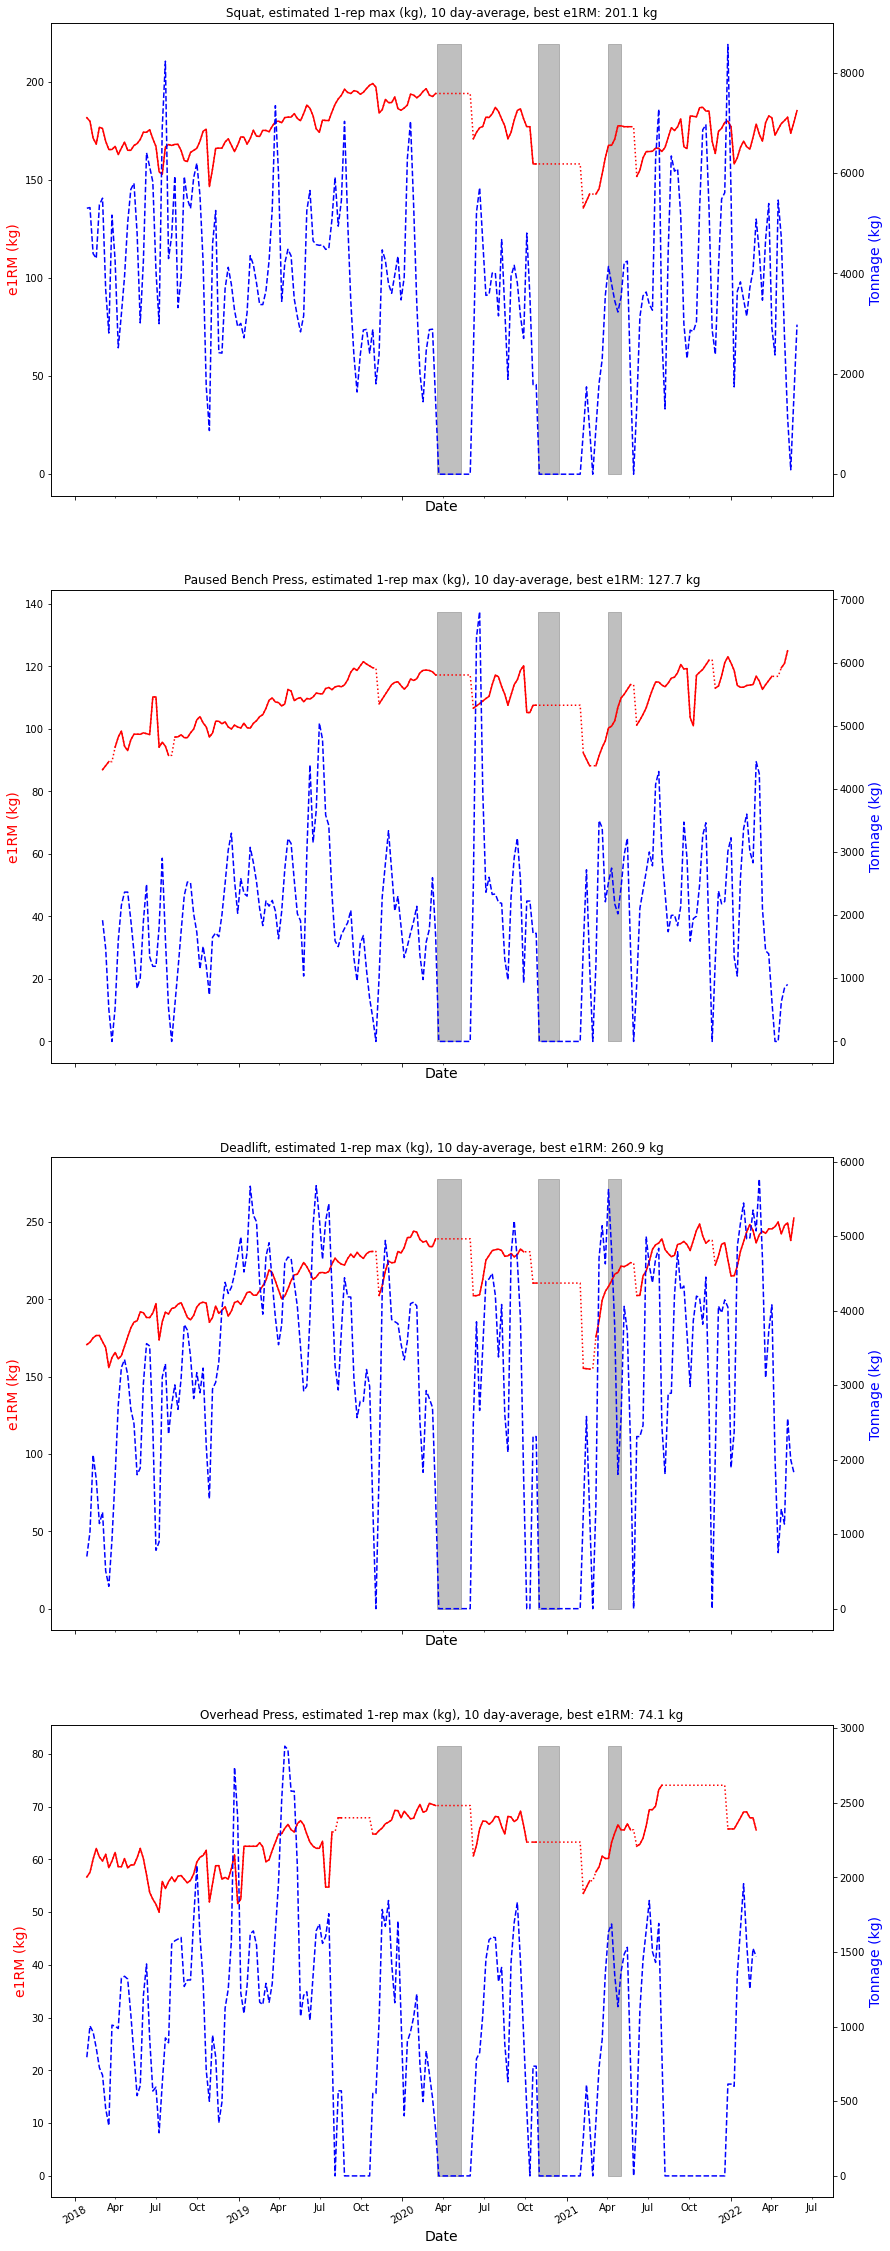

In [19]:
fig, ax = plt.subplots(len(EXERCISES), figsize=[14, 40], sharex=True)

for i, item in enumerate(EXERCISES):
    plot_historical_e1RM(
        e1RM[item],
        item,
        tonnage[item],
        ax[i]
    )

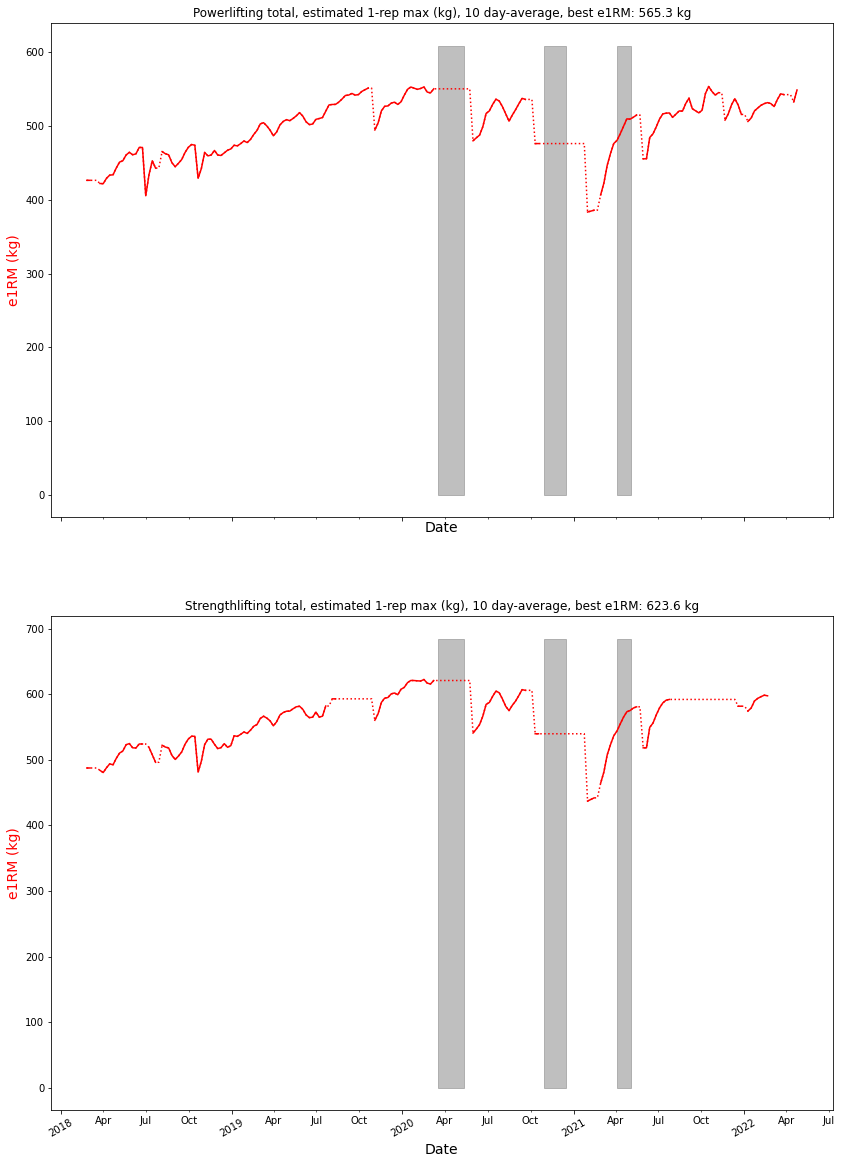

In [10]:
SBD_total = e1RM["Squat"].resample("W", label='left').max() +\
            e1RM["Paused Bench Press"].resample("W", label='left').max() +\
            e1RM["Deadlift"].resample("W", label='left').max()

Strenghtlifting_total = SBD_total + e1RM["Overhead Press"].resample("W", label='left').max()

total_df = pd.DataFrame({
    "Powerlifting total": SBD_total,
    "Strengthlifting total": Strenghtlifting_total
})

fig, ax = plt.subplots(2, figsize=[14, 20], sharex=True)
for i, item in enumerate(total_df.columns):
    plot_historical_e1RM(
        e1RM=total_df[item],
        exercise=item,
        ax=ax[i]
    )

# 4. Yearly charts

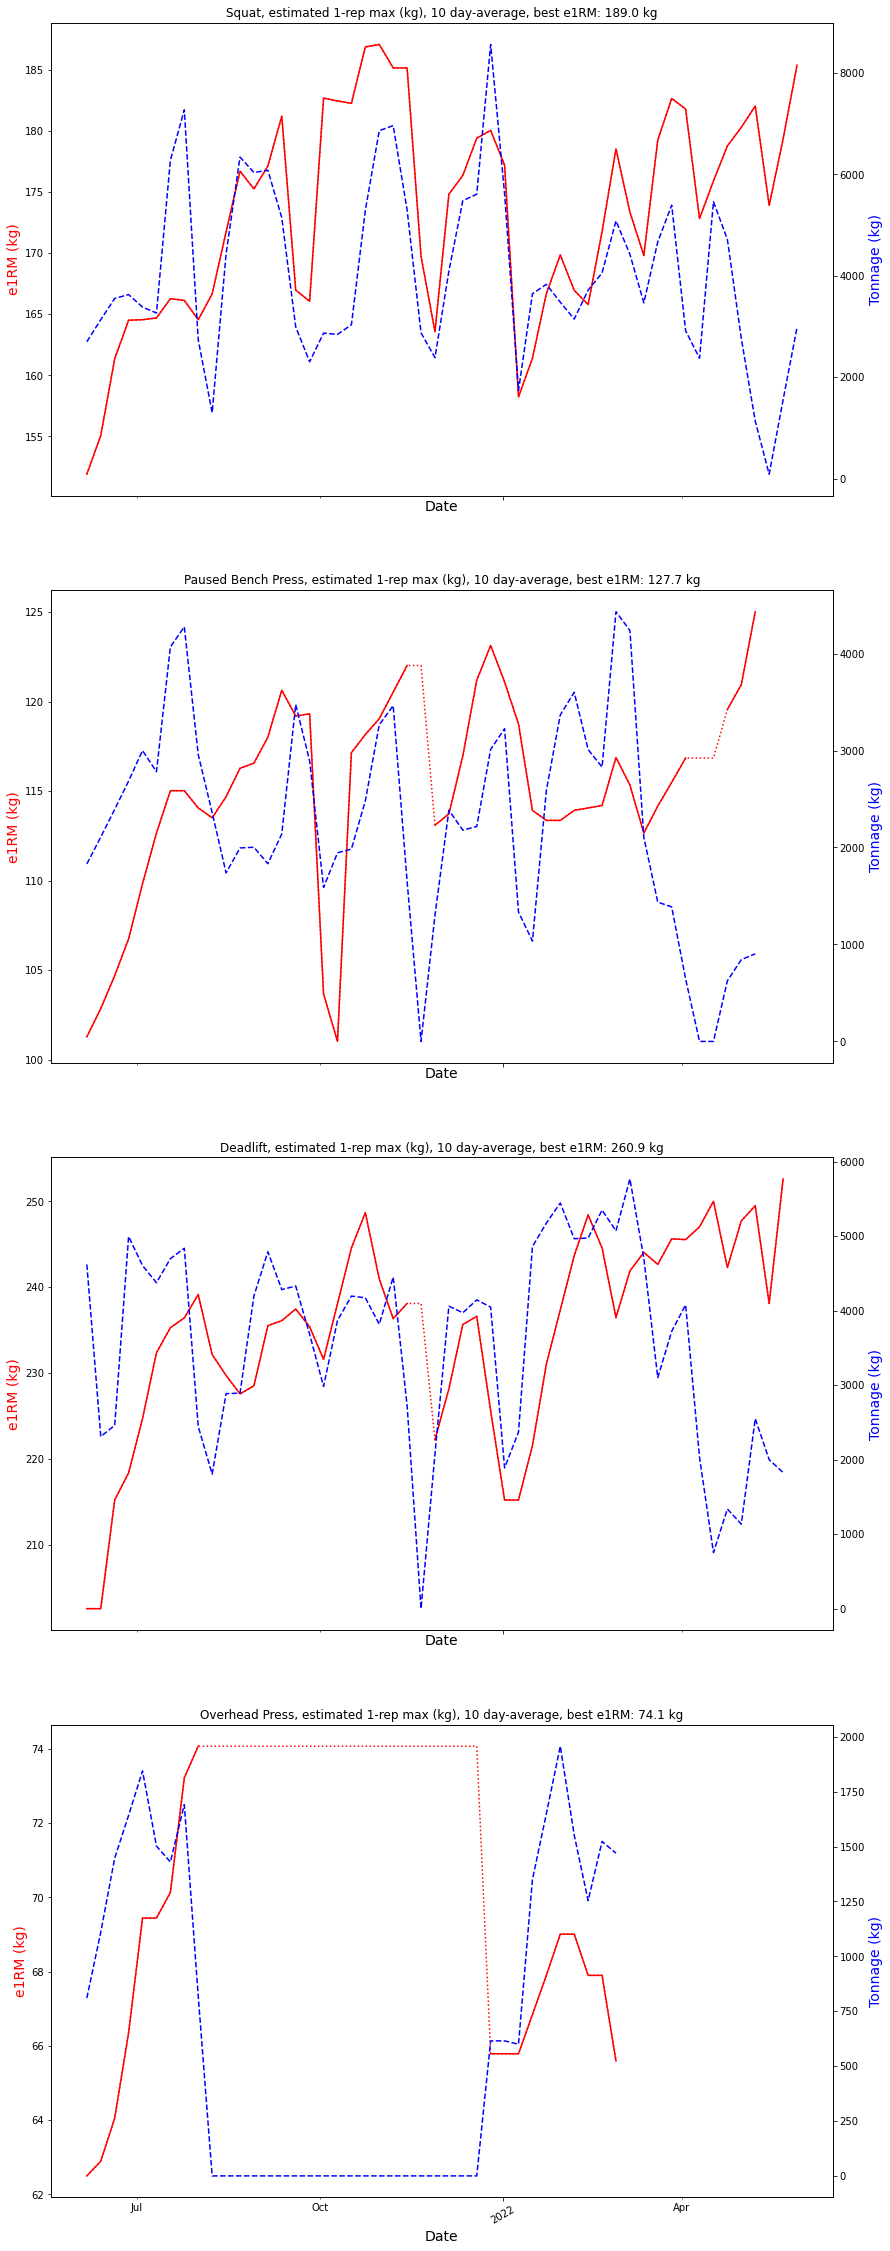

In [11]:
ONE_YEAR_AGO = datetime.now() - relativedelta(years=1)

fig, ax = plt.subplots(len(EXERCISES), figsize=[14, 40], sharex=True)

for i, item in enumerate(EXERCISES):
    plot_historical_e1RM(
        e1RM = e1RM.loc[ONE_YEAR_AGO:, item],
        exercise=item,
        tonnage = tonnage.loc[ONE_YEAR_AGO:, item],
        ax=ax[i]
    )

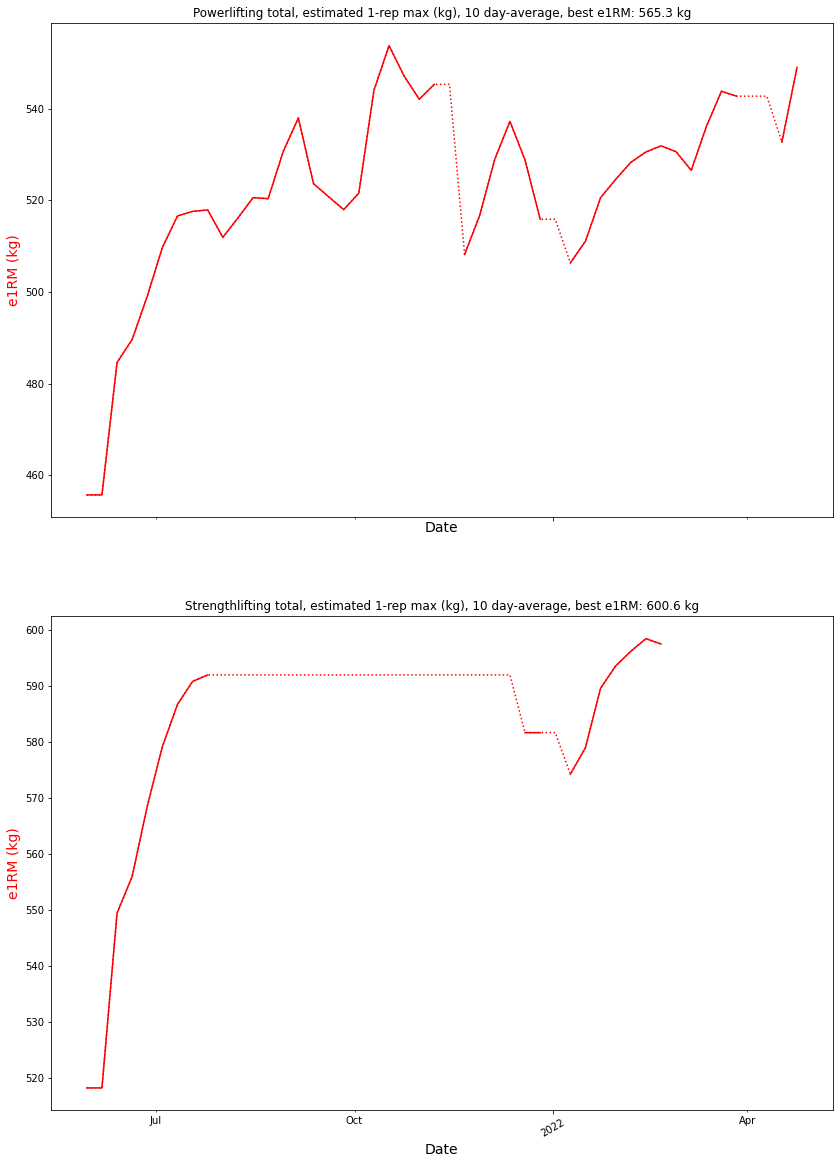

In [12]:
fig, ax = plt.subplots(2, figsize=[14, 20], sharex=True)

for i, item in enumerate(total_df.columns):
    plot_historical_e1RM(
        total_df.loc[ONE_YEAR_AGO:, item],
        exercise = item,
        ax=ax[i]
    )